In [1]:
import numpy as np
import pandas as pd
import os
import re
import torch
import glob
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy import stats
from collections import Counter, defaultdict
import scanpy as sc
from statannotations.Annotator import Annotator
import plotly.graph_objects as go
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

/home/yipingzou2/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
count = 0
dirpaths = glob.glob("./integrate_filtered/*")
for dirpath in dirpaths:
    if os.path.exists(os.path.join(dirpath, "processed_tcr.csv")):
        consensus_result = pd.read_csv(os.path.join(dirpath, "processed_tcr.csv"), sep=",")
        count+=consensus_result.shape[0]
print(count)

9539


把celltype和PB percentage整合进consensus_result里

In [112]:
for resultpath in glob.glob("/mnt/d/dataset/CCA_GSE201425/myresult/integrate_filtered/*PBMC*/consensus_result.csv"):

    dirname = resultpath.split('/')[-2]
    result = pd.read_csv(resultpath, sep=",", index_col="barcode")

    PBsize_trajectory = {}
    result["PB_per"] = np.nan
    for cluster_ID in result.drop_duplicates(subset="cluster", keep="first").cluster.tolist():
        cluster_size = result[result.cluster==cluster_ID].shape[0]
        PB_size = result[(result.cluster==cluster_ID)&(result["sample"].str.contains("PBMC"))].shape[0]
        primary_size = result[(result.cluster==cluster_ID)&(result["sample"].str.contains("primary"))]
        PBsize_trajectory[cluster_ID] = PB_size/cluster_size
        result.loc[result[result.cluster == cluster_ID].index.tolist(), "PB_per"] = PB_size/cluster_size
    result.index = (result["sample"] + '_' + result.index.map(lambda x: x.split('_')[-1]))
    result.index.name = "barcode"
    #result["celltype"] = annotation.loc[result.index, "celltype"]
    break
    #result.to_csv(resultpath)

In [22]:
PBMCanno = pd.read_csv('/mnt/d/TCRdataset/CCA_GSE201425/PBMC_filtered_annotation.csv', sep=",", index_col="barcode")
lymphanno = pd.read_csv('/mnt/d/TCRdataset/CCA_GSE201425/lymph_filtered_annotation.csv', sep=",", index_col="barcode")
primaryanno = pd.read_csv('/mnt/d/TCRdataset/CCA_GSE201425/primary_filtered_annotation.csv', sep=",", index_col="barcode")

for resultpath in glob.glob("/mnt/d/TCRdataset/CCA_GSE201425/myresult/integrate_filtered/*/consensus_result.csv"):

    dirname = resultpath.split('/')[-2]
    result = pd.read_csv(resultpath, sep=",", index_col="barcode")

    result["celltype"] = np.nan
    result.index = (result["sample"] + '_' + result.index.map(lambda x: x.split('_')[-1]))
    result.index.name = "barcode"
    if "PBMC" in resultpath:
        result.loc[list(set(PBMCanno.index.tolist()) & set(result.index.tolist())),"celltype"] = PBMCanno.loc[list(set(PBMCanno.index.tolist()) & set(result.index.tolist())),"celltype"]
        result.loc[list(set(primaryanno.index.tolist()) & set(result.index.tolist())),"celltype"] = primaryanno.loc[list(set(primaryanno.index.tolist()) & set(result.index.tolist())),"celltype"]
    elif "LP" in resultpath:
        result.loc[list(set(lymphanno.index.tolist()) & set(result.index.tolist())),"celltype"] = lymphanno.loc[list(set(lymphanno.index.tolist()) & set(result.index.tolist())),"celltype"]
        result.loc[list(set(primaryanno.index.tolist()) & set(result.index.tolist())),"celltype"] = primaryanno.loc[list(set(primaryanno.index.tolist()) & set(result.index.tolist())),"celltype"]
    result.to_csv(resultpath)


写入cluster size

In [133]:
for resultpath in glob.glob("/mnt/d/dataset/CCA_GSE201425/myresult/integrate_filtered/*/consensus_result.csv"):
    #if "PBMC" in resultpath:
    dirname = resultpath.split('/')[-2]
    print(dirname)
    result = pd.read_csv(resultpath, sep=",", index_col="barcode")
    result["cluster_size"] = np.nan
    for clusterID in result.drop_duplicates(subset="cluster", keep="first").cluster.tolist():
        clustersize = result[result.cluster==clusterID].shape[0]
        result.loc[result[result.cluster==clusterID].index.tolist(), ["cluster_size"]] = clustersize
        #tumor = result[result["sample"].str.contains("primary")]
    result.to_csv(resultpath)

230093_MP
230093_PBMCprimary
230498_LP
230498_PBMCprimary
230723_LP
230723_MP
230723_PBMCprimary
231260_LP
231260_PBMCprimary
357818_MP
357818_PBMCprimary


In [133]:
tumorresults = []
pbmcresults = []
lymphresults = []
for resultpath in glob.glob("/mnt/d/dataset/CCA_GSE201425/myresult/integrate_filtered/*/consensus_result.csv"):
    if "PBMC" in resultpath:
        result = pd.read_csv(resultpath, sep=",", index_col="barcode")
        tumor = result[result["sample"].str.contains("primary")]
        pbmc = result[result["sample"].str.contains("PBMC")]
        tumor["cluster"] = tumor['cluster'].astype(str) + ':' + tumor['sample']
        pbmc["cluster"] = pbmc['cluster'].astype(str) + ':' + pbmc['sample']
        tumorresults.append(tumor)
        pbmcresults.append(pbmc)
    if "LP" in resultpath:
        result = pd.read_csv(resultpath, sep=",", index_col="barcode")
        lymph = result[result["sample"].str.contains("lymph")]
        lymph["cluster"] = lymph['cluster'].astype(str) + ':' + lymph['sample']
        lymphresults.append(lymph)
tumorresults = pd.concat(tumorresults)
pbmcresults = pd.concat(pbmcresults)
lymphresults = pd.concat(lymphresults)

/tmp/ipykernel_70151/1147274432.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor["cluster"] = tumor['cluster'].astype(str) + ':' + tumor['sample']
/tmp/ipykernel_70151/1147274432.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbmc["cluster"] = pbmc['cluster'].astype(str) + ':' + pbmc['sample']
/tmp/ipykernel_70151/1147274432.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 18 glyphs before
Glyph names: ['.notdef', '.null', 'C', 'eight', 'five', 'four', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'six', 'space', 't', 'three', 'two', 'u', 'zero']
Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 27, 38, 81, 82, 87, 88]
Closed glyph list over 'GSUB': 18 glyphs after
Glyph names: ['.notdef', '.null', 'C', 'eight', 'five', 'four', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'six', 'space', 't', 'three', 'two', 'u', 'zero']
Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 27, 38, 81, 82, 87, 88]
Closing glyph list over 'MATH': 18 glyphs before
Glyph names: ['.notdef', '.null', 'C', 'eight', 'five', 'four', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'six', 'space', 't', 'three', 'two', 'u', 'zero']
Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 2

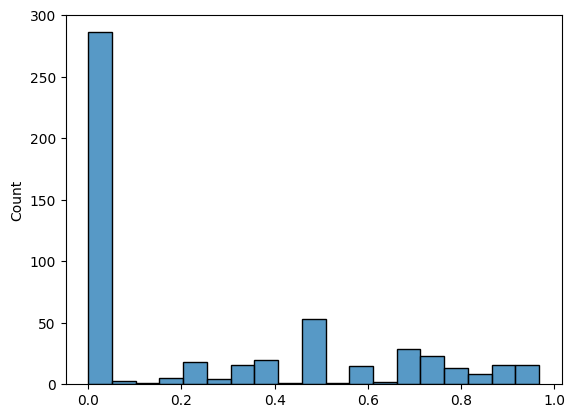

In [144]:
sns.histplot(tumorresults.drop_duplicates(subset="cluster", keep="first").PB_per.tolist(),binwidth=0.05)
plt.savefig("/mnt/d/论文/TCRclub Manuscript/figures/CCA/primary_distribution.pdf", dpi=300)

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 17 glyphs before
Glyph names: ['.notdef', '.null', 'C', 'eight', 'five', 'four', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'six', 'space', 't', 'two', 'u', 'zero']
Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 23, 24, 25, 27, 38, 81, 82, 87, 88]
Closed glyph list over 'GSUB': 17 glyphs after
Glyph names: ['.notdef', '.null', 'C', 'eight', 'five', 'four', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'six', 'space', 't', 'two', 'u', 'zero']
Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 23, 24, 25, 27, 38, 81, 82, 87, 88]
Closing glyph list over 'MATH': 17 glyphs before
Glyph names: ['.notdef', '.null', 'C', 'eight', 'five', 'four', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'six', 'space', 't', 'two', 'u', 'zero']
Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 23, 24, 25, 27, 38, 81, 82, 87, 88]
Closed glyph

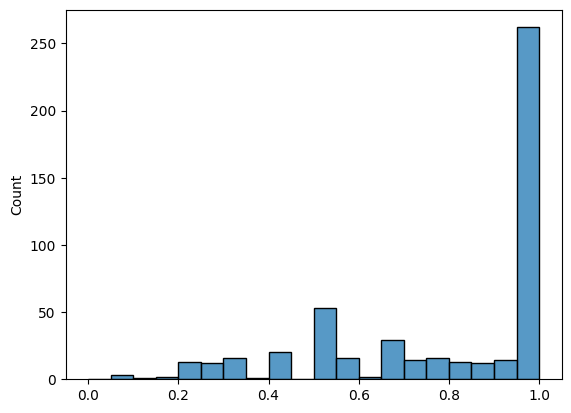

In [142]:
sns.histplot(pbmcresults.drop_duplicates(subset="cluster", keep="first").PB_per.tolist(),binwidth=0.05,binrange=[0,1.0])
plt.savefig("/mnt/d/论文/TCRclub Manuscript/figures/CCA/PBMC_distribution.pdf", dpi=300)

maxp pruned


cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 16 glyphs before
Glyph names: ['.notdef', '.null', 'C', 'eight', 'four', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'six', 'space', 't', 'two', 'u', 'zero']
Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 23, 25, 27, 38, 81, 82, 87, 88]
Closed glyph list over 'GSUB': 16 glyphs after
Glyph names: ['.notdef', '.null', 'C', 'eight', 'four', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'six', 'space', 't', 'two', 'u', 'zero']
Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 23, 25, 27, 38, 81, 82, 87, 88]
Closing glyph list over 'MATH': 16 glyphs before
Glyph names: ['.notdef', '.null', 'C', 'eight', 'four', 'n', 'nonmarkingreturn', 'o', 'one', 'period', 'six', 'space', 't', 'two', 'u', 'zero']
Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 23, 25, 27, 38, 81, 82, 87, 88]
Closed glyph list over 'MATH': 16 glyphs after
Glyph names: 

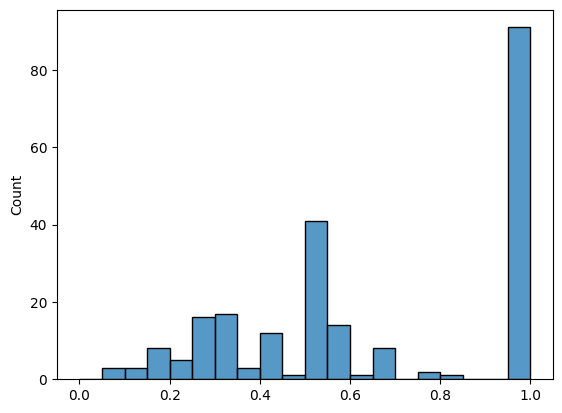

In [143]:
sns.histplot(lymphresults.drop_duplicates(subset="cluster", keep="first").lymph_per.tolist(),binwidth=0.05,binrange=[0,1.0])
plt.savefig("/mnt/d/论文/TCRclub Manuscript/figures/CCA/lymph_distribution.pdf", dpi=300)

In [231]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatterpolar(
  r=df["percentage"].tolist(),
  theta=df.index.tolist(),
  fill='toself'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    ),
  ),
  showlegend=False
)
fig.write_image("/mnt/d/论文/TCRclub Manuscript/figures/CCA/celltype_related_distribution.pdf")


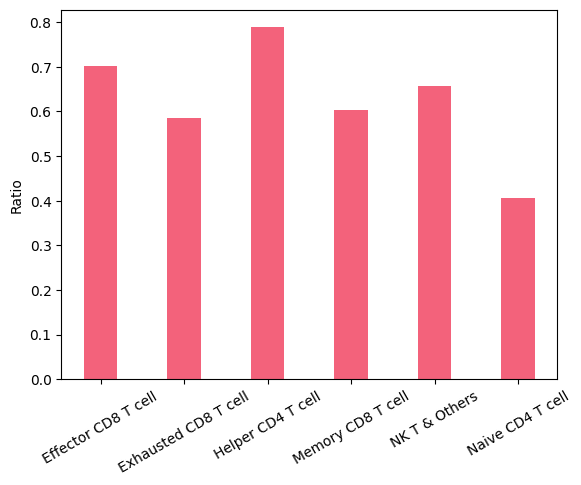

In [127]:
PBMCanno = pd.read_csv('/mnt/d/dataset/CCA_GSE201425/PBMC_filtered_annotation.csv', sep=",", index_col="barcode")
celltypes = PBMCanno.drop_duplicates(subset="celltype", keep="first").celltype.tolist()

counts = []
for celltype in sorted(celltypes):
    related = PBMCanno[(PBMCanno.PB_per < 1) & (PBMCanno.celltype==celltype)].shape[0]
    unrelated = PBMCanno[(PBMCanno.PB_per == 1) & (PBMCanno.celltype==celltype)].shape[0]
    counts.append(related / (unrelated+related))

plt.bar(sorted(celltypes), counts, width=0.4, color="#F3627B", label="PB-related/PB-unrelated T cells")
plt.xticks(rotation=30)
plt.ylabel("Ratio")
plt.savefig("/mnt/d/论文/TCRclub Manuscript/figures/CCA/PB_cellchange_ratio.pdf", dpi=300)

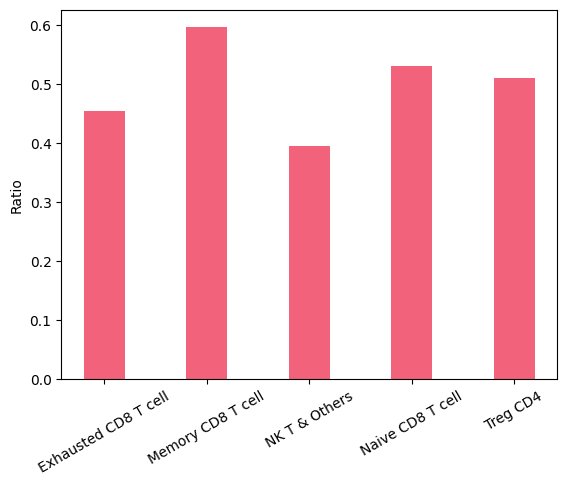

In [128]:
lymphanno = pd.read_csv('/mnt/d/dataset/CCA_GSE201425/lymph_filtered_annotation.csv', sep=",", index_col="barcode")
celltypes = lymphanno.drop_duplicates(subset="celltype", keep="first").celltype.tolist()

counts = []
for celltype in sorted(celltypes):
    related = lymphanno[(lymphanno.lymph_per < 1) & (lymphanno.celltype==celltype)].shape[0]
    unrelated = lymphanno[(lymphanno.lymph_per == 1) & (lymphanno.celltype==celltype)].shape[0]
    counts.append(related / (unrelated+related))

plt.bar(sorted(celltypes), counts, width=0.4, color="#F3627B", label="PB-related/PB-unrelated T cells")
plt.xticks(rotation=30)
plt.ylabel("Ratio")
plt.savefig("/mnt/d/论文/TCRclub Manuscript/figures/CCA/lymph_cellchange_ratio.pdf", dpi=300)

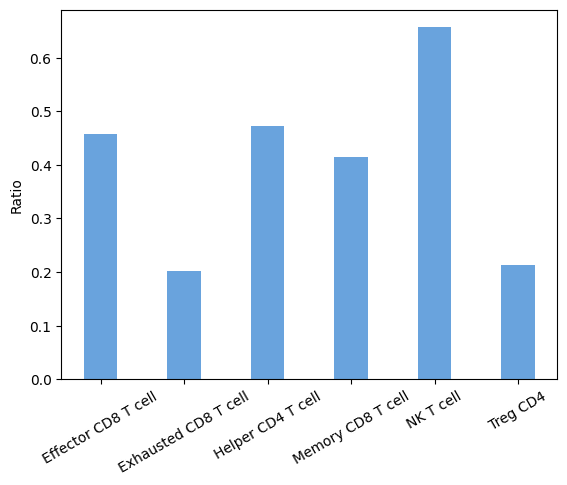

In [132]:
primaryanno = pd.read_csv('/mnt/d/dataset/CCA_GSE201425/primary_filtered_annotation.csv', sep=",", index_col="barcode")
celltypes = primaryanno.drop_duplicates(subset="celltype", keep="first").celltype.tolist()

counts = []
for celltype in sorted(celltypes):
    unrelated = primaryanno[(primaryanno.PB_per == 0) & (primaryanno.celltype==celltype)].shape[0]
    related = primaryanno[(primaryanno.PB_per > 0) & (primaryanno.celltype==celltype)].shape[0]
    counts.append(related / (unrelated+related))

plt.bar(sorted(celltypes), counts, width=0.4, color="#69A3DD", label="PB-related/PB-unrelated T cells")
plt.xticks(rotation=30)
plt.ylabel("Ratio")
plt.savefig("/mnt/d/论文/TCRclub Manuscript/figures/CCA/primary_cellchange_ratio.pdf", dpi=300)

统计Effector Trajectory Plot中各State细胞的比例

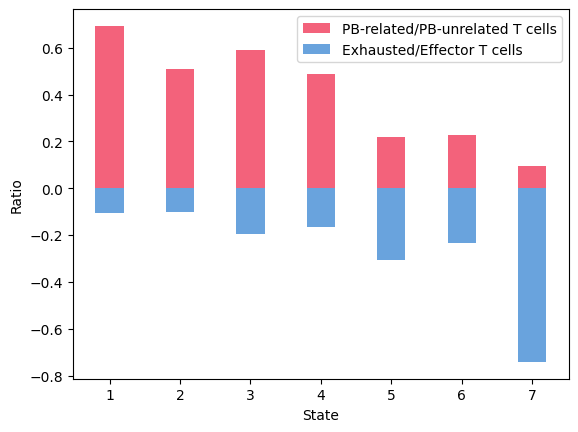

In [104]:
effector = pd.read_csv("./Effector_state.csv", index_col=0)
highvslow = {}
effectvsexh = {}
real_state = [1,7,2,6,3,5,4]
for i, state in enumerate(real_state):
    counts = effector[effector.State==(state)].stage.value_counts()
    high = counts.loc["high"]
    low = counts.loc["low"]
    exh = counts.loc["Exhausted CD8 T cell"]
    highvslow[i] = high/(high+low)
    effectvsexh[i] = exh/(high+low+exh)

x = sorted(set(effector.State.tolist()))

plt.bar(x, list(highvslow.values()), width=0.4, color="#F3627B", label="PB-related/PB-unrelated T cells")
#x = [x+0.4 for x in sorted(set(effector.State.tolist()))]
plt.bar(x, [-1*value for value in effectvsexh.values()], width=0.4, color="#69A3DD", label="Exhausted/Effector T cells")
#plt.yticks([2,1,0,-1,-2,-3],[2,1,0,1,2,3])
plt.ylabel("Ratio")
plt.xlabel("State")
plt.legend()
plt.savefig("/mnt/d/论文/TCRclub Manuscript/figures/CCA/trajectory/effector_ratio.pdf", dpi=300)

统计Memory Trajectory Plot中各State细胞的比例

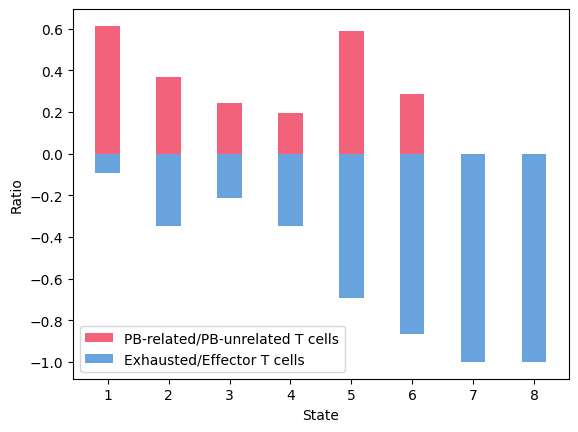

In [105]:
memory = pd.read_csv("./Memory_state.csv", index_col=0)
highvslow = {}
memoryvsexh = {}
real_state = [6,7,9,8,3,4,2,1]
for i, state in enumerate(real_state):
    counts = memory[memory.State==(state)].stage.value_counts()
    
    high = counts.loc["high"] if "high" in set(counts.index.tolist()) else 0
    low = counts.loc["low"] if "low" in set(counts.index.tolist()) else 0
    exh = counts.loc["Exhausted CD8 T cell"] if "Exhausted CD8 T cell" in set(counts.index.tolist()) else 0
    highvslow[i] = high/(high+low) if high + low >0 else 0
    memoryvsexh[i] = exh/(high+low+exh)

x = sorted([1,2,3,4,5,6,7,8])
plt.bar(x, list(highvslow.values()), width=0.4, color="#F3627B", label="PB-related/PB-unrelated T cells")
#x = [x+0.4 for x in sorted(set(effector.State.tolist()))]
plt.bar(x, [-1*value for value in memoryvsexh.values()], width=0.4, color="#69A3DD", label="Exhausted/Effector T cells")
#plt.yticks([2,1,0,-1,-2,-3],[2,1,0,1,2,3])
plt.ylabel("Ratio")
plt.xlabel("State")
plt.legend()
plt.savefig("/mnt/d/论文/TCRclub Manuscript/figures/CCA/trajectory/memory_ratio.pdf", dpi=300)

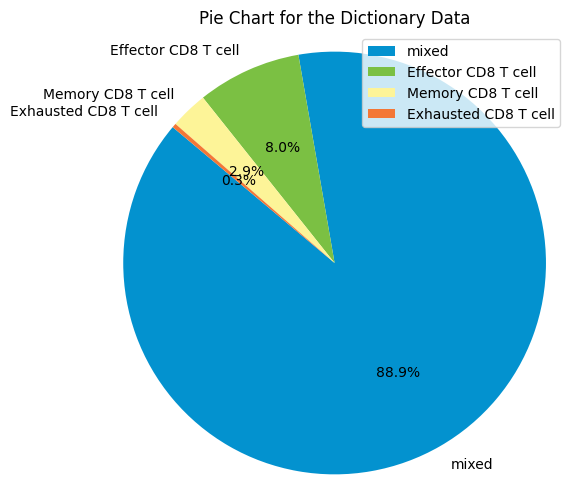

In [84]:

resultpaths = glob.glob("/mnt/d/TCRdataset/CCA_GSE201425/myresult/integrate_filtered/*/*consensus_result.csv")
results = []
for resultpath in resultpaths:
    result = pd.read_csv(resultpath, sep=",", index_col="barcode")
    result = result[result["sample"].str.contains("primary_focus")]
    result["cluster"] = result["sample"].astype(str) + ":" + result["cluster"].astype(str)
    results.append(result)
results = pd.concat(results)
celltypes = results.celltype.unique()
#unique_cdr3_result = results.drop_duplicates(subset="cdr3", keep="first")
pie_count = defaultdict(lambda: 0)
for cluster_id in results.cluster.unique():
    club = results[results.cluster == cluster_id]
    unique_cdr3 = club.drop_duplicates(subset="cdr3", keep="first").cdr3.tolist()
    if len(unique_cdr3)>1:
        count = (club.celltype.value_counts()).to_dict()
        if len(count.keys()) == 1:
            pie_count[list(count.keys())[0]] += 1
        else:
            pie_count["mixed"] += 1

pie_count = {key:value for key,value in pie_count.items() if ("CD4" not in key) and ("NK" not in key)}
labels = list(pie_count.keys())
sizes = list(pie_count.values())
# Plotting the pie chart
colors = ['#ee4035', '#f37736', '#fdf498', '#7bc043', '#0392cf']
colors.reverse()
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adding a title
plt.legend()
plt.title('Pie Chart for the Dictionary Data')
plt.savefig("/mnt/d/论文/TCRclub Manuscript/figures/CCA/CD8type_ditribution1.pdf", dpi=300)

In [81]:
resultpaths = glob.glob("/mnt/d/TCRdataset/CCA_GSE201425/myresult/integrate_filtered/*/*consensus_result.csv")
results = []
for resultpath in resultpaths:
    result = pd.read_csv(resultpath, sep=",", index_col="barcode")
    result = result[result["sample"].str.contains("primary_focus")]
    result["cluster"] = result["sample"].astype(str) + ":" + result["cluster"].astype(str)
    results.append(result)
results = pd.concat(results)
celltypes = results.celltype.unique()
#unique_cdr3_result = results.drop_duplicates(subset="cdr3", keep="first")
pie_count = defaultdict(lambda: 0)
for cluster_id in results.cluster.unique():
    club = results[results.cluster == cluster_id]
    unique_cdr3 = club.drop_duplicates(subset="cdr3", keep="first").cdr3.tolist()
    if len(unique_cdr3)>1:
        count = (club.celltype.value_counts()).to_dict()
        count = {k: count[k] for k in sorted(count) if ("CD4" not in k)&("NK" not in k)}
        if len(count.keys()) != 1:
            pie_count[':'.join(list(count.keys()))] += 1
pie_count = {k: v for k, v in sorted(pie_count.items(), key=lambda item: item[1], reverse=True)}
pie_count.pop('')

6

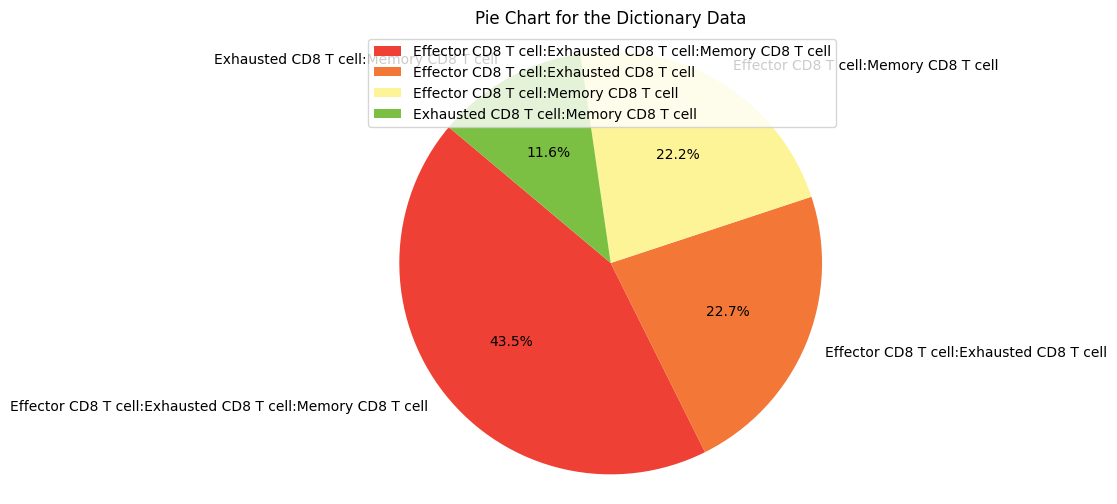

In [83]:
pie_count = {key:value for key,value in pie_count.items()}
labels = list(pie_count.keys())
sizes = list(pie_count.values())
# Plotting the pie chart
plt.figure(figsize=(6, 6))
colors = ['#ee4035', '#f37736', '#fdf498', '#7bc043', '#0392cf']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors = colors, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adding a title
plt.title('Pie Chart for the Dictionary Data')
plt.legend()
plt.savefig("/mnt/d/论文/TCRclub Manuscript/figures/CCA/CD8type_ditribution2.pdf", dpi=300)

['p=3.93e-01', 'p=3.93e-01', 'p=3.45e-01']
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

lymph_node vs. PBMC: p=3.93e-01
PBMC vs. primary_focus: p=3.45e-01
lymph_node vs. primary_focus: p=3.93e-01


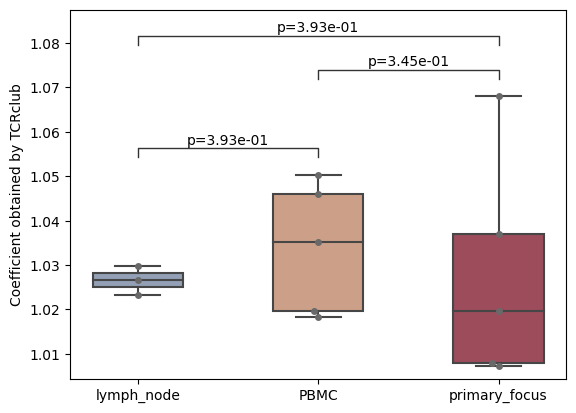

In [3]:
datadirs = ["/mnt/d/TCRdataset/CCA_GSE201425/myresult/samples"]

A_corr = defaultdict(list)
for datadir in datadirs:
    dirnames = [dirname for dirname in os.listdir(datadir) if os.path.isdir(os.path.join(datadir, dirname))]
    for dirname in dirnames:
        dirpath = os.path.join(datadir, dirname)
        result_path = os.path.join(dirpath, "k10_maxk10_beta1e-07.npy")
        if not os.path.exists(result_path):
            continue
        results = np.load(result_path, allow_pickle=True).item()
        for sort_creteria in ["loss"]:#, "samekloss", "distance_variance"
            results = dict(sorted(results.items(), key=lambda x: x[1][sort_creteria]))
            if sort_creteria == "distance_variance":
                topk = 15
            else:
                topk = 15
            top_result = {k:v for i, (k, v) in enumerate(results.items()) if i in range(0,topk)}
        #average_W = np.mean(np.vstack([values['W'] for key, values in top_result.items()]), axis=0).reshape(1,-1)
        average_A = np.mean(np.hstack([values['A'] for key, values in top_result.items()]), axis=1).reshape(-1,1)
        if "PBMC" in dirname:
            A_corr["PBMC"].append(np.mean(average_A))
        if "primary_focus" in dirname:
            A_corr["primary_focus"].append(np.mean(average_A))
        if "lymph_node" in dirname:
            A_corr["lymph_node"].append(np.mean(average_A))
            
tissue = []
A_values = []
for key, value in A_corr.items():
    tissue.extend([key]*len(value))
    A_values.extend(value)
df = pd.DataFrame({'tissue':tissue, 'A_value':A_values})


plotting_parameters = {
        'data': df,
        'x': 'tissue',
        'y': 'A_value',
        'order':["lymph_node","PBMC","primary_focus"],
    }
lymph_node = df[df["tissue"]=='lymph_node'].A_value.tolist()
PBMC = df[df["tissue"]=='PBMC'].A_value.tolist()
primary_focus = df[df["tissue"]=='primary_focus'].A_value.tolist()

g = sns.boxplot(palette=['#8d9fbb','#d89c7c','#aa3e53'], **plotting_parameters,width=0.5) #"RdYlGn"
sns.swarmplot(ax=g, color="dimgray",**plotting_parameters)
g.set_xticklabels(plotting_parameters['order'],fontsize=10)
g.set_title("")
g.set_ylabel("Coefficient obtained by TCRclub", fontsize=10)
g.set_xlabel("")

pvalues = [
    stats.mannwhitneyu(lymph_node, PBMC, alternative="two-sided").pvalue,
    stats.mannwhitneyu(lymph_node, primary_focus, alternative="two-sided").pvalue,
    stats.mannwhitneyu(PBMC, primary_focus, alternative="two-sided").pvalue
]

candidate_pairs = [("lymph_node","PBMC"), ("lymph_node","primary_focus"),
                   ("PBMC","primary_focus")]
pairs = []
formatted_pvalues = []
for idx in np.where(np.array(pvalues)<1)[0]:
    pairs.append(candidate_pairs[idx.item()])
    formatted_pvalues.append(f'p={pvalues[idx.item()]/2:.2e}')
print(formatted_pvalues)
if pairs:
    annotator = Annotator(g, pairs,**plotting_parameters)
    annotator.configure(loc="inside",line_height=0.03,line_width=1)
    annotator.set_custom_annotations(formatted_pvalues)
    annotator.annotate()
plt.savefig("/mnt/d/论文/TCRclub Manuscript/figures/CCA/Coefficient.pdf", dpi=300)

0.5
0.16
0.43243243243243246
0.20512820512820512
0.36363636363636365
0.23809523809523808
0.26573426573426573
0.16
0.4166666666666667
0.2


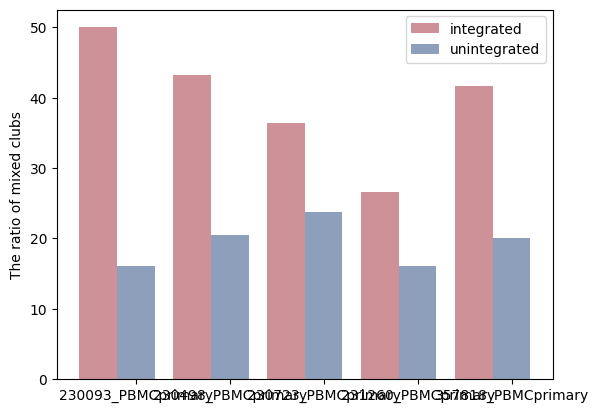

In [66]:
dirnames = os.listdir("myresult/unintegrate_filtered")
integrated = []
unintegrated = []
for dirname in dirnames:
    filtered = pd.read_csv("/mnt/d/TCRdataset/CCA_GSE201425/myresult/integrate_filtered/{}/consensus_result.csv".format(dirname), index_col="barcode")
    filtered = filtered.drop_duplicates(subset="cdr3", keep="first")
    clustercount = 0
    mixcount = 0
    for clusterID in filtered.cluster.unique():
        if len(filtered[filtered.cluster == clusterID]) > 1:
            clustercount += 1
            if filtered[filtered.cluster == clusterID]["sample"].value_counts().shape[0] > 1:
                mixcount += 1
                #print(filtered[filtered.cluster == clusterID]["sample"].value_counts())
    print(mixcount/clustercount)
    integrated.append(100 * mixcount/clustercount)

    unfiltered = pd.read_csv("myresult/unintegrate_filtered/{}/consensus_result.csv".format(dirname), index_col="barcode")
    unfiltered = unfiltered.drop_duplicates(subset="cdr3", keep="first")
    clustercount = 0
    mixcount = 0
    for clusterID in unfiltered.cluster.unique():
        if len(unfiltered[unfiltered.cluster == clusterID]) > 1:
            clustercount += 1
            if unfiltered[unfiltered.cluster == clusterID]["sample"].value_counts().shape[0] > 1:
                mixcount += 1
                #print(unfiltered[unfiltered.cluster == clusterID]["sample"].value_counts())
    print(mixcount/clustercount)
    unintegrated.append(100 *mixcount/clustercount)

width=0.4
x = list(range(len(dirnames)))
a = plt.bar(x, integrated, width=width, label="integrated", fc="#cf9198")
for i in range(len(dirnames)):
    x[i] = x[i]+width
b = plt.bar(x, unintegrated, width=width, label="unintegrated", tick_label=dirnames, fc="#8d9fbb")
plt.ylabel("The ratio of mixed clubs")
plt.legend()
plt.savefig("/mnt/d/论文/TCRclub Manuscript/figures/CCA/integration_necessary.pdf")

In [76]:
filtered = pd.read_csv("/mnt/d/TCRdataset/CCA_GSE201425/myresult/integrate_filtered/230093_PBMCprimary/consensus_result.csv".format(dirname), index_col="barcode")
filtered = filtered.drop_duplicates(subset="cdr3", keep="first")
clustercount = 0
mixcount = 0
for clusterID in filtered.cluster.unique():
    if len(filtered[filtered.cluster == clusterID]) > 1:
        clustercount += 1
        if filtered[filtered.cluster == clusterID]["sample"].value_counts().shape[0] > 1:
            mixcount += 1
            print(filtered[filtered.cluster == clusterID]["sample"].value_counts())
print(mixcount/clustercount)

230093_PBMC             1
230093_primary_focus    1
Name: sample, dtype: int64
230093_PBMC             1
230093_primary_focus    1
Name: sample, dtype: int64
230093_PBMC             1
230093_primary_focus    1
Name: sample, dtype: int64
230093_PBMC             1
230093_primary_focus    1
Name: sample, dtype: int64
230093_PBMC             1
230093_primary_focus    1
Name: sample, dtype: int64
230093_PBMC             1
230093_primary_focus    1
Name: sample, dtype: int64
230093_PBMC             1
230093_primary_focus    1
Name: sample, dtype: int64
230093_PBMC             1
230093_primary_focus    1
Name: sample, dtype: int64
230093_PBMC             1
230093_primary_focus    1
Name: sample, dtype: int64
230093_PBMC             1
230093_primary_focus    1
Name: sample, dtype: int64
230093_PBMC             1
230093_primary_focus    1
Name: sample, dtype: int64
230093_PBMC             1
230093_primary_focus    1
Name: sample, dtype: int64
230093_PBMC             1
230093_primary_focus    1


In [78]:
unfiltered = pd.read_csv("myresult/unintegrate_filtered/230723_PBMCprimary/consensus_result.csv".format(dirname), index_col="barcode")
unfiltered = unfiltered.drop_duplicates(subset="cdr3", keep="first")
clustercount = 0
mixcount = 0
for clusterID in unfiltered.cluster.unique():
    if len(unfiltered[unfiltered.cluster == clusterID]) > 1:
        clustercount += 1
        if unfiltered[unfiltered.cluster == clusterID]["sample"].value_counts().shape[0] > 1:
            mixcount += 1
            print(unfiltered[unfiltered.cluster == clusterID]["sample"].value_counts())
print(mixcount/clustercount)

230723_primary_focus    1
230723_PBMC             1
Name: sample, dtype: int64
230723_primary_focus    1
230723_PBMC             1
Name: sample, dtype: int64
230723_primary_focus    1
230723_PBMC             1
Name: sample, dtype: int64
230723_primary_focus    1
230723_PBMC             1
Name: sample, dtype: int64
230723_primary_focus    1
230723_PBMC             1
Name: sample, dtype: int64
230723_primary_focus    1
230723_PBMC             1
Name: sample, dtype: int64
230723_primary_focus    1
230723_PBMC             1
Name: sample, dtype: int64
230723_primary_focus    1
230723_PBMC             1
Name: sample, dtype: int64
230723_primary_focus    1
230723_PBMC             1
Name: sample, dtype: int64
230723_primary_focus    1
230723_PBMC             1
Name: sample, dtype: int64
230723_primary_focus    1
230723_PBMC             1
Name: sample, dtype: int64
230723_primary_focus    1
230723_PBMC             1
Name: sample, dtype: int64
230723_primary_focus    1
230723_PBMC             1


In [1]:
import celltypist
from celltypist import models

/home/yipingzou2/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [101]:
model = models.Model.load(model = 'Immune_All_Low.pkl')
model.cell_types

array(['Age-associated B cells', 'Alveolar macrophages', 'B cells',
       'CD16+ NK cells', 'CD16- NK cells', 'CD8a/a', 'CD8a/b(entry)',
       'CMP', 'CRTAM+ gamma-delta T cells', 'Classical monocytes',
       'Cycling B cells', 'Cycling DCs', 'Cycling NK cells',
       'Cycling T cells', 'Cycling gamma-delta T cells',
       'Cycling monocytes', 'DC', 'DC precursor', 'DC1', 'DC2', 'DC3',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ELP',
       'ETP', 'Early MK', 'Early erythroid', 'Early lymphoid/T lymphoid',
       'Endothelial cells', 'Epithelial cells', 'Erythrocytes',
       'Erythrophagocytic macrophages', 'Fibroblasts',
       'Follicular B cells', 'Follicular helper T cells', 'GMP',
       'Germinal center B cells', 'Granulocytes', 'HSC/MPP',
       'Hofbauer cells', 'ILC', 'ILC precursor', 'ILC1', 'ILC2', 'ILC3',
       'Intermediate macrophages', 'Intestinal macrophages',
       'Kidney-resident macrophages', 'Kupffer cells',
       'Large pre-B cell

In [49]:
datapaths = glob.glob("/mnt/d/dataset/CCA_GSE201425/sample_filtered/*/*rnacount.csv")
annotation = []
for datapath in datapaths:
    #rnacount = pd.read_csv(datapath, sep=",", index_col="barcode")
    sampleName = re.findall(r'(.*?)_filtered', datapath.split('/')[-2])[0]
    #rnacount.index = sampleName + '_' +rnacount.index
    predictions = celltypist.annotate(datapath, model = 'Immune_All_Low.pkl')
    predictions.predicted_labels.index = sampleName + '_' + predictions.predicted_labels.index
    predictions.predicted_labels.index.name = "barcode"
    predictions.predicted_labels.to_csv(os.path.join(os.path.dirname(datapath), "{}_annotation.csv".format(sampleName)))
    #rnafile.append(rnacount)
#rnafile = pd.concat(rnafile)

📁 Input file is '/mnt/d/dataset/CCA_GSE201425/sample_filtered/230093_primary_focus_filtered/rnacount.csv'
⏳ Loading data


🔬 Input data has 468 cells and 16977 genes
🔗 Matching reference genes in the model
🧬 5356 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


In [128]:
celltypes = ['Regulatory T cells', 'Tcm/Naive cytotoxic T cells', 'Tem/Temra cytotoxic T cells', 'Tem/Trm cytotoxic T cells', 'Treg(diff)', 'Trm cytotoxic T cells']

In [129]:
Memory_CD4 = ['Memory CD4+ cytotoxic T cells']
Helper_CD4 = ['Tcm/Naive helper T cells', 'Tem/Effector helper T cells', 'Tem/Effector helper T cells PD1+','Type 1 helper T cells','Type 17 helper T cells']


In [130]:
datapaths = glob.glob("/mnt/d/dataset/CCA_GSE201425/myresult/integrate_filtered/*PBMC*/consensus_result.csv")
for datapath in datapaths:
    sampleName = re.findall(r'(.*?)_PBMCprimary', datapath.split('/')[-2])[0]
    consensus = pd.read_csv(datapath, index_col="barcode")
    consensus = consensus.drop(["predicted_labels"],axis=1)
    PB_annotation = pd.read_csv("/mnt/d/dataset/CCA_GSE201425/sample_filtered/{}_PBMC_filtered/{}_annotation.csv".format(sampleName,sampleName+"_PBMC"), index_col="barcode")
    tumor_annotation = pd.read_csv("/mnt/d/dataset/CCA_GSE201425/sample_filtered/{}_primary_focus_filtered/{}_annotation.csv".format(sampleName,sampleName+"_primary_focus"), index_col="barcode")
    annotation = pd.concat([PB_annotation, tumor_annotation])
    consensus = consensus.join(annotation)
    consensus.loc[~consensus.predicted_labels.isin(celltypes+Memory_CD4+Helper_CD4),"predicted_labels"] = "NK T cell & Others"
    consensus.loc[consensus.predicted_labels.isin(Memory_CD4),"predicted_labels"] = "Memory CD4 T cell"
    consensus.loc[consensus.predicted_labels.isin(Helper_CD4),"predicted_labels"] = "Helper CD4 T cell"
    assert(not consensus.isnull().values.any())
    consensus.to_csv(datapath)

In [131]:
datapaths = glob.glob("/mnt/d/dataset/CCA_GSE201425/myresult/integrate_filtered/*LP*/consensus_result.csv")
for datapath in datapaths:
    sampleName = re.findall(r'(.*?)_LP', datapath.split('/')[-2])[0]
    consensus = pd.read_csv(datapath, index_col="barcode")
    consensus = consensus.drop(["predicted_labels"],axis=1)
    lymph_annotation = pd.read_csv("/mnt/d/dataset/CCA_GSE201425/sample_filtered/{}_lymph_node_filtered/{}_annotation.csv".format(sampleName,sampleName+"_lymph_node"), index_col="barcode")
    tumor_annotation = pd.read_csv("/mnt/d/dataset/CCA_GSE201425/sample_filtered/{}_primary_focus_filtered/{}_annotation.csv".format(sampleName,sampleName+"_primary_focus"), index_col="barcode")
    annotation = pd.concat([lymph_annotation, tumor_annotation])
    #consensus = consensus.drop(['PB_per',"celltype"], axis=1)
    consensus = consensus.join(annotation)
    consensus.loc[~consensus.predicted_labels.isin(celltypes+Memory_CD4+Helper_CD4),"predicted_labels"] = "NK T cell & Others"
    consensus.loc[consensus.predicted_labels.isin(Memory_CD4),"predicted_labels"] = "Memory CD4 T cell"
    consensus.loc[consensus.predicted_labels.isin(Helper_CD4),"predicted_labels"] = "Helper CD4 T cell"
    assert(not consensus.isnull().values.any())
    consensus.to_csv(datapath)